In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from multiprocessing import Pool
from tqdm import tqdm

import sys
sys.path.insert(0, "../src")
from swe import ShallowOne, ShallowOneLinear
from figures import figure_sizes

fe.set_log_level(40)

In [2]:
def run_model(nx):
    dt = 0.01
    t_final = 10.
    nt = np.int64(t_final / dt)
    t_grid = np.arange(0., t_final, dt)

    swe = ShallowOne(
        control=dict(nx=nx, dt=dt, theta=0.6, simulation="immersed_bump"),
        params=dict(nu=1e-6, bump_centre=10))
    
    t = 0.
    for i in range(nt):
        t += swe.dt
        swe.solve(t)
    
    return swe.du


def compute_error(nx):
    duh = run_model(nx)
    return fe.errornorm(swe_reference, duh)

In [3]:
swe_reference = run_model(3000)

In [4]:
nx = [250, 500, 750, 1000, 1250]

# models = [run_model(n) for n in nx]
p = Pool(8)
out = p.map(compute_error, nx)

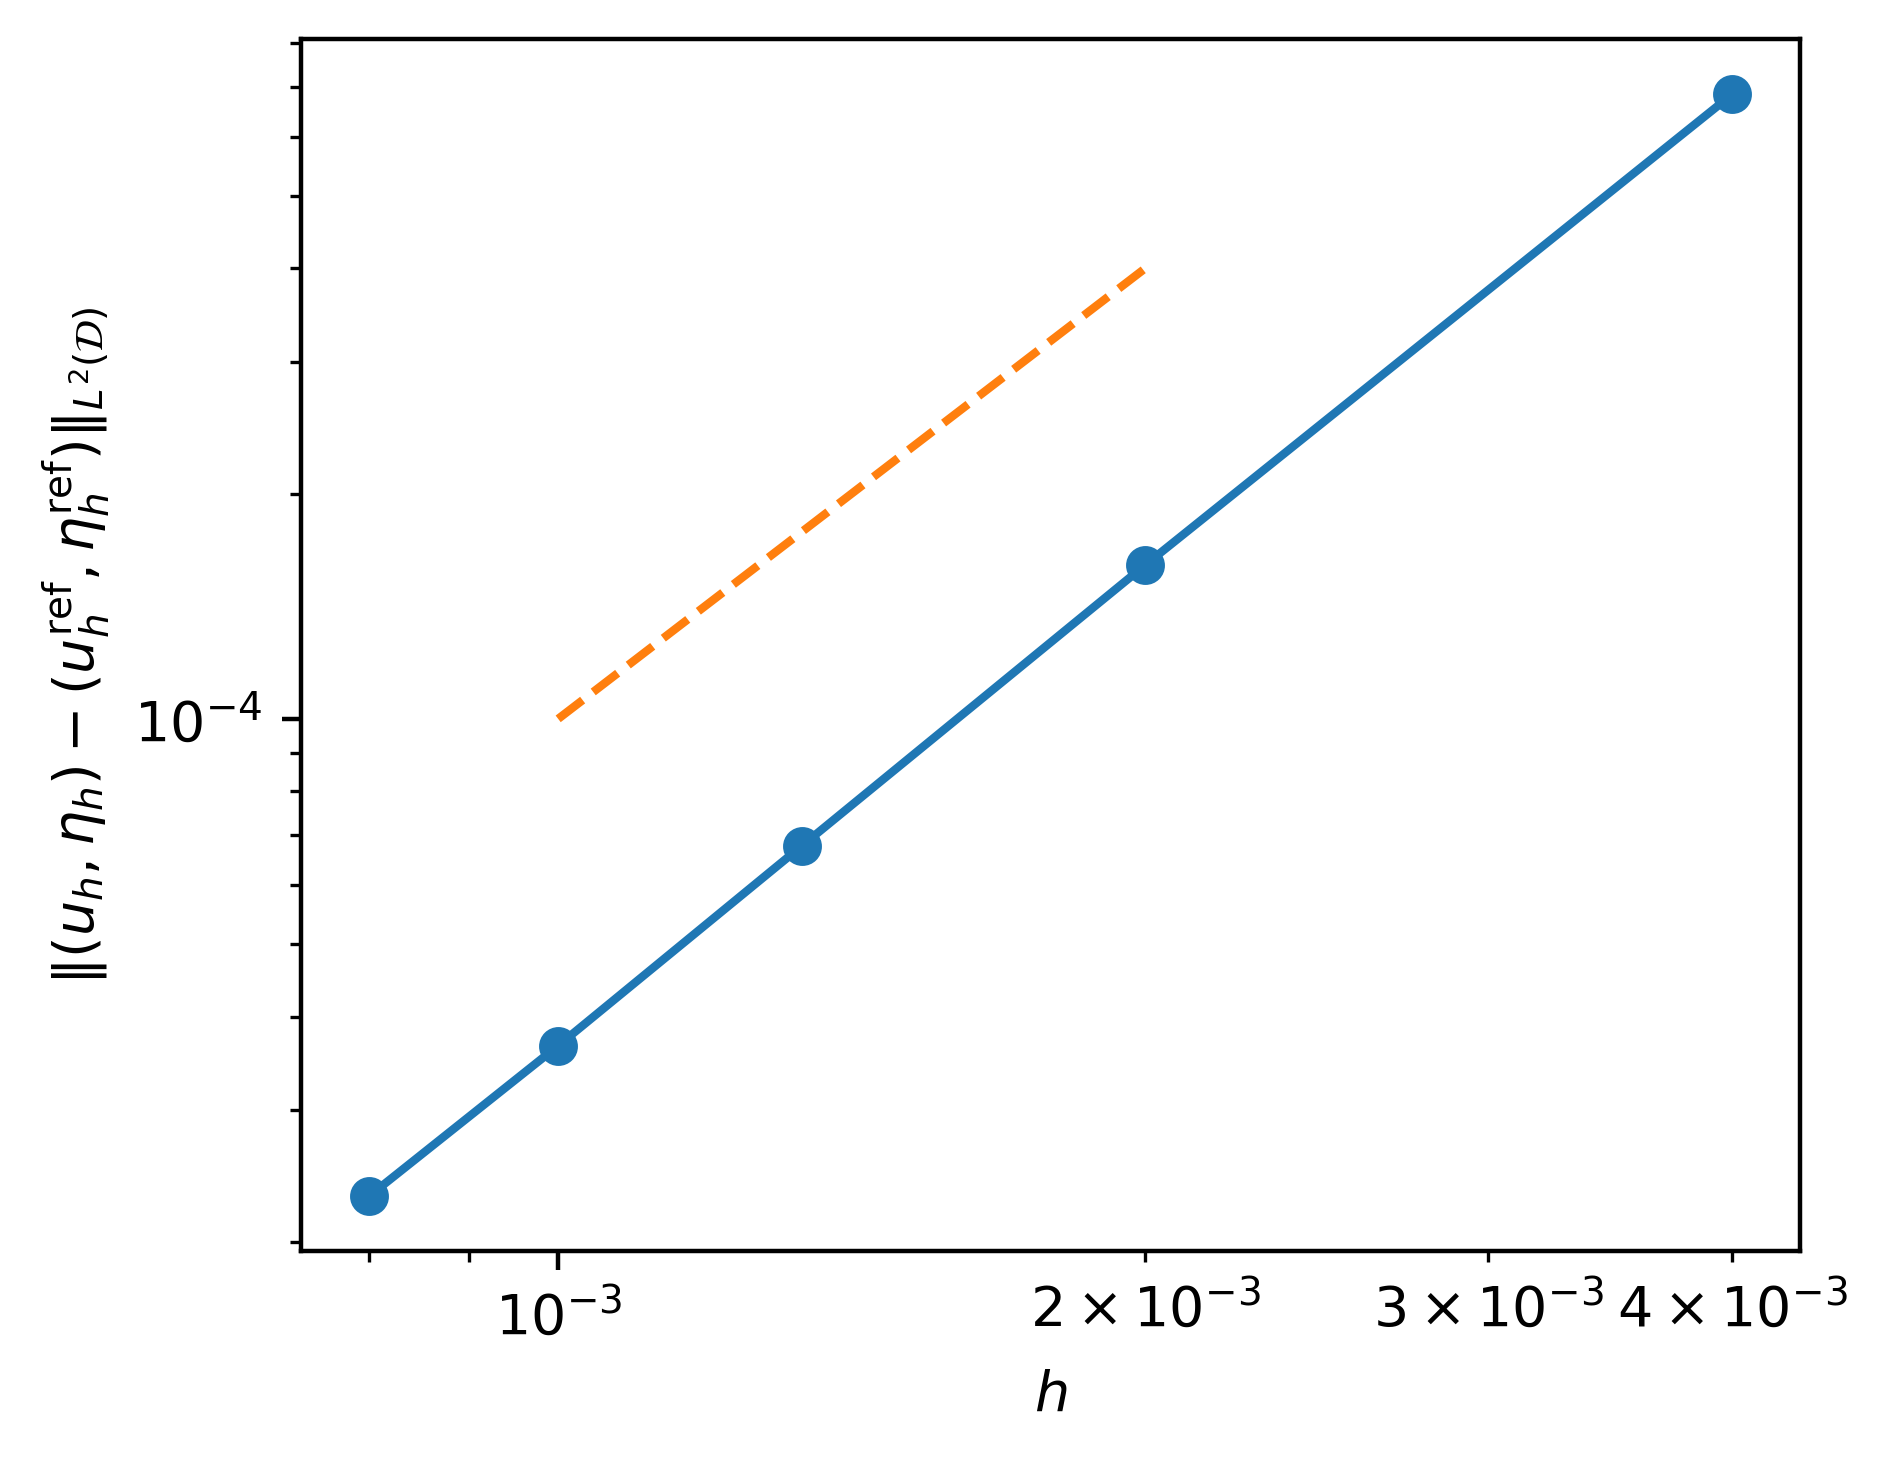

In [5]:
h = np.array([1 / n for n in nx])
error = np.array(out)
grid_reference = np.linspace(1e-3, 2e-3)
line_reference = 1e2 * grid_reference**2

fig, ax = plt.subplots(1, 1, 
                       constrained_layout=True, 
                       figsize=(1.3 * figure_sizes["halfwidth"], 
                                1 * figure_sizes["halfwidth"]),
                       dpi=400)
ax.loglog(h, error, marker="o")
ax.loglog(grid_reference, line_reference, "--")
ax.set_xlabel(r"$h$")
ax.set_ylabel(r"$\Vert (u_h, \eta_h) - (u_h^{\mathrm{ref}}, \eta_h^{\mathrm{ref}}) \Vert_{L^2(\mathcal{D})} $")
plt.savefig("../figures/fem-convergence.pdf")

In [6]:
print(error)

from scipy.stats import linregress
print(linregress(np.log(h), np.log(error)))

[6.83202663e-04 1.60511479e-04 6.76396956e-05 3.65767230e-05
 2.30258794e-05]
LinregressResult(slope=2.1101244962541728, intercept=4.36697667051568, rvalue=0.9999887870268876, pvalue=4.507277509738771e-08, stderr=0.005769344765485905, intercept_stderr=0.037522929069098654)
